In [4]:
import graph_tool as gt

from graph_tool.all import graph_draw

import inspect
from itertools import combinations
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path, PosixPath

import pandas as pd
import scipy
#User
import pynetio as mio
from myitertools import exhaust, forp
import predicates as pred
from utils import doc, ls, psrc



home = Path.home()

if Path(".").absolute() == PosixPath('/home/aji/Projects/dev/pynet/pyext'):
    src = Path(".")
else:
    src = home / 'Projects/dev/pynet'
data = src / 'data'
lip = data / 'sars-cov-2-LiP'
multi = data / 'multi-proteomics'
apms_stuk = multi / '41586_2021_3493_MOESM6_ESM.xlsx'
apms_stuk_sheetname = 'A - Significant interactions'
apms_gordon = data / 'sars-cov-2-ppi/41586_2020_2286_MOESM5_ESM.xlsx'

#Variables for testing lip funcitons

xls_paths = list(mio.gen_excelpaths_from_dir(lip))
lip1 = xls_paths[1]

lipgen = mio.parse_lip_xls_file(lip1)

apms = pd.read_excel(apms_gordon)


def spec_counts_str_col_to_array(sc):
    def sc_row_to_list(scrow):
        mylist = []
        for i in scrow.split('|'):
            mylist.append(int(i))
        return mylist
    row_list = []
    for row in sc:
        row_list.append(sc_row_to_list(row))
    return np.array(row_list, dtype=np.uint8)

def filter_out_prey(apms):
    return apms[apms['SaintScore'] != 0]


def apms_pre_processing(apms):
    apms = apms.copy()
    apms[['scr1', 'scr2', 'scr3']]=spec_counts_str_col_to_array(apms['Spec'])
    apms = filter_out_prey(apms)
    
    apms['log10 p(prey|sc)'] = np.log10(apms['SaintScore'])
    return apms

apms = apms_pre_processing(apms)

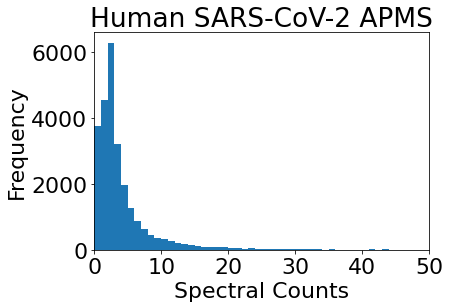

In [15]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


#The histogram of spectral counts
plt.hist(np.ravel(list(apms[i].values for i in ['scr1', 'scr2', 'scr3'])), bins=250)
plt.title("Human SARS-CoV-2 APMS")
plt.xlabel('Spectral Counts')
plt.xlim(0, 50)
plt.ylabel("Frequency")
plt.show()

(array([ 593.,  318.,  230.,  544.,  379.,  598.,  760., 1905.,  404.,
        2776.]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ]),
 <BarContainer object of 10 artists>)

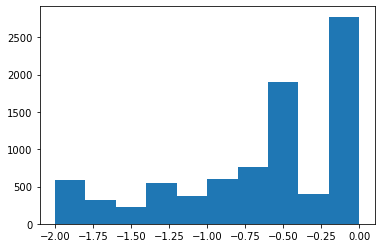

In [2]:
plt.hist(apms['log10 p(prey|sc)'])

In [3]:
"""
gid indexes into the sequence of ordered undirected graphs
mantissa indexes into the sequence of ordered subgraphs
with ne edges
"""

def femax(vmax):
    """
    Returns the maximum number of edges in the undirected graph
    """
    return vmax*(vmax - 1) // 2
def edge_combs(emax):
    """
    Returns an edge combination generator
    The value is the number of combinations
    The index is the number of edges
    
    e.g., index 0 1 2 3
          value 1 3 3 1
    """
    return (int(scipy.special.comb(emax, i)) for i in range(emax+1))
            
def ne(gid, vmax):
    """
    Returns the number of edges for a given gid & vmax
    """
    emax = femax(vmax)
    
    #The index of combs is the edge number
    combs = list(edge_combs(emax))
    assert sum(combs) == 2**emax
    
    solutions = 0
    edges = 0
    while gid >= solutions:
        solutions += combs[edges]
        edges +=1
    return edges - 1

def base(nedges, vmax):
    """
    returns the base for nedges and vmax
    The graph id (gid) = base + mantissa
    """
    emax = femax(vmax)
    combs = list(edge_combs(emax))
    return sum(combs[0:nedges])

def mantissa(gid, vmax):
    """
    returns the mantissa for gid, vmax
    gid = base + mantissa
    """
    b = base(ne(gid, vmax), vmax)
    return gid - b

def next_vertex(i):
    """
    Count the next vertex, undefined over vmax
    """
    return i + 1

def prev_vertex(i):
    """
    Count the previous vertex, undefined for i < 1
    """
    return i - 1

def next_edge(e, vertex_n_max):
    """
    Return the next edge in the sequence
    """
    if e[1] < vertex_n_max - 1: return (e[0], e[1]+1)
    else: return (e[0] + 1, e[0] + 2)
    
def prev_edge(e, vmax):
    """
    Count the previous edge in the sequence
    """
    #if e > first_e:
    # (0, 2) -> (0, 1)
    if e[1] > e[0] + 1: return (e[0], e[1] - 1)
    # (1, 2) -> (0, 3)
    else: return (e[0] - 1, vmax - 1)

def generate_eseq(estart, vertex_n_max):
    yield estart
    while estart != (vertex_n_max - 2, vertex_n_max - 1):
        next_e = next_edge(estart, vertex_n_max)
        estart = next_e
        yield estart   

def permutations(nitems):
    perms = []
    for i in range(nitems):
        for j in range(i+1, nitems):
            perms.append((i, j))
    return perms


def generate_graph(gid, vmax):
    """
    Return an ordered elist from a graph id and n vertices
    """
    nedges = ne(gid, vmax)
    b = base(nedges, vmax)
    m = mantissa(gid, vmax)
    
    if gid == 0:
        return []
    else:
        all_edges = list(generate_eseq((0, 1), vmax))
        combinations_iter = combinations(range(len(all_edges)), nedges)
        
        for i, combo in enumerate(combinations_iter):
            #print(i, combo)
            if i == m:
                eseq = []
                #print(combo)
                for idx in combo:
                    eseq.append(all_edges[idx])
                return eseq
            
def test_next_prev(vmax):
    print("fEdges for vmax = {vmax}")
    print(' e      next   prev   pne    npe   b')
    for e in generate_eseq((0, 1), vmax):
        ne = next_edge(e, vmax)
        pe = prev_edge(e, vmax)
        pne = prev_edge(ne, vmax)
        npe = next_edge(pe, vmax)
        b = e == npe
        
        print(e, ne, pe, pne, npe, b)
    

vmax = 3
emax = femax(vmax)
solutions = 2**emax
print('solutions {:.1E}'.format(solutions))
print('gid >= base')
print('gid = base + mantissa')
y = list(edge_combs(emax))
print(y)
print('gid ne base mantissa  graph')

if solutions <= 256:
    for i in range(2**emax):
        nedges = ne(i, vmax)
        g = generate_graph(i, vmax)
        print(f'{i}   {ne(i, vmax)}   {base(nedges, vmax)}\t{mantissa(i, vmax)}  {g}')

solutions 8.0E+00
gid >= base
gid = base + mantissa
[1, 3, 3, 1]
gid ne base mantissa  graph
0   0   0	0  []
1   1   1	0  [(0, 1)]
2   1   1	1  [(0, 2)]
3   1   1	2  [(1, 2)]
4   2   4	0  [(0, 1), (0, 2)]
5   2   4	1  [(0, 1), (1, 2)]
6   2   4	2  [(0, 2), (1, 2)]
7   3   7	0  [(0, 1), (0, 2), (1, 2)]


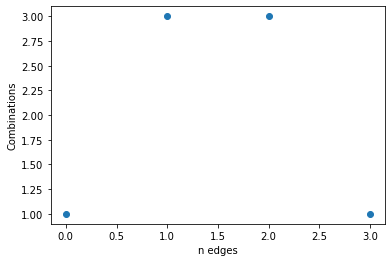

In [4]:
plt.scatter(range(len(y)), y)
plt.xlabel('n edges')
plt.ylabel('Combinations')
plt.show()

In [5]:
def score_functor(M, D):
    return ll_apms(M, D) + lp_apms(M, D)


def rho(x, y):
    """
    Returns the correlation matrix for x and y
    """
    return np.corrcoef(x)

def pc(x, y, z):
    """
    Returns the partial correlation
    x, y, z : rho_xy, rho_xz, rho_zy
    """
    def d(y):
        return np.sqrt(1 - (y)**2)
    return x - y*z / (d(y)*d(z))

def precision(m):
    return -np.linalg.inv(np.corrcoef(C.T))

In [8]:
m = np.random.randint(2, size=(32, 3))
omega = np.cov(m)
#precision = np.linalg.inv(omega)

def thresh(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    elif x==0:
        return 0

In [14]:
omega

array([[ 0.33333333,  0.        ,  0.        , ..., -0.33333333,
        -0.16666667, -0.16666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.33333333,  0.        ,  0.        , ...,  0.33333333,
         0.16666667,  0.16666667],
       [-0.16666667,  0.        ,  0.        , ...,  0.16666667,
         0.33333333, -0.16666667],
       [-0.16666667,  0.        ,  0.        , ...,  0.16666667,
        -0.16666667,  0.33333333]])

In [171]:
def apms_fm(M, D):
    """
    solutions 8.0E+00
    gid >= base
    gid = base + mantissa
    [1, 3, 3, 1]
    gid graph                         rho         upc_01
    0   []                               
    1   [(0, 1)]
    2   [(0, 2)]
    3   [(1, 2)]
    4   [(0, 1), (0, 2)]
    5   [(0, 1), (1, 2)]
    6   [(0, 2), (1, 2)]             02 12 01     upc_01=0  
    7   [(0, 1), (0, 2), (1, 2)]     01, 02, 12,  upc = 0
    
    """
    columns = ['r01', 'r02','r12', 'u01','u02','u12']
    x = np.array([[0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 1, 0, 0],])
    d = pd.DataFrame(x, columns=columns, index='gid')
def ll_apms_triplet(M, D):
    """
    p(d | )
    """

    pass

        

    
    

def ll_apms(M, D):
    """
    XY XZ YZ  g
    +  +  +   xyz, xzy, yzx, xyzx
    +  +  0   xy xz
    +  0  +
    +  -  0
    +  0  -
    +  -  -
    0  0  0
    """

def lp_apms(preyseries,D):
    """
    The log probability
                Preys SaintScore
    preylist : [name, log10 p(prey|spectral counts)]
    The lp will be negative because 0 <= p(prey|sc) < 1
    """
    return sum(preyseries['log10 p(prey|sc)'])

def plot_score():
    """
    Plots the score distributions
    
    """

def test_partial_correlation():
    
    
    
    perms = [(0.9, 0.9, 0.9),
             (0.9, 0.9, 0),
             (0.9, 0.9, 0.7),
            ]
    pcs = list(pc(*i) for i in perms)
    d = pd.DataFrame(perms, columns=['rho_xy', 'rho_xz', 'rho_yz'])
    #d['rho_xy|z']=pcs
    d['upc_xy'] = d.iloc[:, 0] - d.iloc[:, 1]*d.iloc[:, 2]
    d['upc_xz'] = d.iloc[:, 1] - d.iloc[:, 0]*d.iloc[:, 2]
    d['upc_yz'] = d.iloc[:, 2] - d.iloc[:, 1]*d.iloc[:, 0]
    return d
    

In [72]:
d = 10
x = np.random.poisson(5, d)
sqrtx = np.sqrt(x)
theta = np.random.rand(d)
phi = np.random.rand(d, d)
phi = np.tril(phi)

In [51]:
theta

array([0.20806469, 0.29199938, 0.7233623 , 0.59132775])

In [57]:
np.exp(theta.T*sqrtx + np.matmul(np.matmul(sqrtx.T, phi), sqrtx))

array([1.30277927e+16, 1.29864314e+16, 2.39015754e+16, 4.10775512e+16])

In [61]:
np.exp(np.matmul(theta.T, sqrtx) + np.matmul(np.matmul(sqrtx.T, phi), sqrtx))

2.6178653409686768e+17

In [63]:
import math
math.fa

In [67]:
np.sqrt(x)

array([2.        , 1.41421356, 1.41421356, 2.64575131])

In [74]:
def fac_sum(x):
    rsum = 0
    for xi in x:
        rsum+=np.log(math.factorial(xi))
    return rsum

def poisson_sqr(theta, phi, x):
    sqrtx = np.sqrt(x)
    return np.exp(np.matmul(theta.T, sqrtx) + np.matmul(np.matmul(sqrtx.T, phi), sqrtx) - fac_sum(x))

    
    

In [77]:
poisson_sqr(theta, phi, x)

5.836746804612088e+42

In [188]:
x = list(combinations([0,0, 0, 1, 1, 1], 3))
for i in range(1, 5): x.pop(i)
for i in range(1, 3): x.pop(i)

In [189]:
x


[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (1, 1, 1)]

In [135]:
pc(-0.9, -0.9, -0.9)

-5.163157894736845

In [136]:
(-2)**2

4

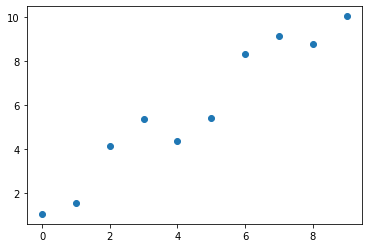

In [33]:
x = np.arange(0, 10)
y = x + 3*np.random.rand(10)
plt.scatter(x, y)

In [34]:
np.corrcoef(x, y)

array([[1.        , 0.96439468],
       [0.96439468, 1.        ]])

In [29]:
?np.random.rand

Text(0, 0.5, 'frequency')

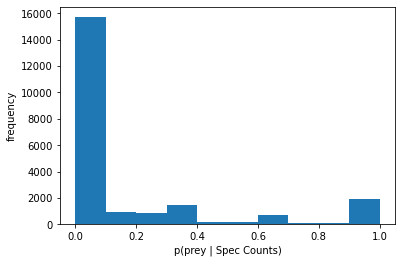

In [24]:
plt.hist(apms['SaintScore'])
plt.xlabel('p(prey | Spec Counts)')
plt.ylabel('frequency')

Text(0, 0.5, 'MIST')

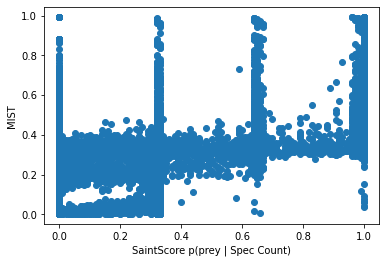

In [23]:
plt.scatter(apms['SaintScore'], apms['MIST'])
plt.xlabel('SaintScore p(prey | Spec Count)')
plt.ylabel('MIST')

In [15]:
def npreys(df, baitname):
    return sum(df['Bait']==baitname)

def gen_apms_n_preys_per_bait(apms):
    for bait in set(apms['Bait']):
        yield (bait, npreys(apms, bait))
npreys = list(gen_apms_n_preys_per_bait(apms))
npreys

[('SARS-CoV2 nsp1', 592),
 ('SARS-CoV2 nsp11', 925),
 ('SARS-CoV2 E', 859),
 ('SARS-CoV2 orf3b', 753),
 ('SARS-CoV2 nsp2', 918),
 ('SARS-CoV2 nsp15', 559),
 ('SARS-CoV2 orf6', 779),
 ('SARS-CoV2 orf3a', 974),
 ('SARS-CoV2 nsp12', 620),
 ('SARS-CoV2 N', 584),
 ('SARS-CoV2 M', 1245),
 ('SARS-CoV2 orf7a', 971),
 ('SARS-CoV2 nsp14', 475),
 ('SARS-CoV2 Spike', 820),
 ('SARS-CoV2 orf9c', 1462),
 ('SARS-CoV2 nsp4', 952),
 ('SARS-CoV2 nsp5', 540),
 ('SARS-CoV2 nsp9', 684),
 ('SARS-CoV2 orf8', 1106),
 ('SARS-CoV2 nsp13', 994),
 ('SARS-CoV2 nsp5_C145A', 365),
 ('SARS-CoV2 nsp6', 1019),
 ('SARS-CoV2 nsp10', 443),
 ('SARS-CoV2 nsp8', 1017),
 ('SARS-CoV2 nsp7', 893),
 ('SARS-CoV2 orf9b', 732),
 ('SARS-CoV2 orf10', 872)]

859

In [5]:
t1 = [(0, 1)]
t2 = [(0, 2)]
t3 = [(1, 2)]
t4 = [(0, 1), (0, 2)]
t5 = [(0, 1), (1, 2)]
t6 = [(0, 1), (0, 2), (1, 2)]

#
t3_4 = [(0, 3)]


master = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


tests = {3:[t1, t2, t3, t4, t5, t6],
         4:[[(0, 1)], #4 1 6 1 : 1 : master[gid-1]
            [(0, 2)], #4 1 6 2 : 2
            [(0, 3)], #4 1 6 3 : 3
            [(1, 2)], #4 1 6 4 : 4
            [(1, 3)], #4 1 6 5 : 5
            [(2, 3)], #4 1 6 6 : 6
            [(0, 1), (0, 2)], #4 2 5 1 : 7 master[0:gid] = master[]
            [(0, 1), (0, 3)], #4 2 5 2 : 8
            [(0, 1), (1, 2)], #4 2 5 3 : 9
            [(0, 1), (1, 3)], #4 2 5 4 : 10
            [(0, 1), (2, 3)], #4 2 5 5 : 11
            [(0, 2), (0, 3)], #4 2 4 1 : 12 master[1:gid]
            [(0, 2), (1, 2)], #
            [(0, 2), (1, 3)],
            [(0, 2), (2, 3)],
            [(0, 3), (1, 2)],
            [(0, 3), (1, 3)],
            [(0, 3), (2, 3)],
            [(1, 2), (1, 3)],
            [(1, 2), (2, 3)],
            [(1, 3), (2, 3)],
            [(0, 1), (0, 2), (0, 3)],
            [(0, 1), (0, 2), (1, 2)],
            [(0, 1), (0, 2), (1, 3)],
            [(0, 1), (0, 2), (2, 3)],
            [(0, 1), (0, 3), (1, 2)],
            [(0, 1), (0, 3), (1, 3)],
            [(0, 1), (0, 3), (2, 3)]
            [(0, 1), (0, 2), (0, 3), (1, 2)]
           ]}


# 4 choose 2
# 1, 2 | 1, 3 | 1

for key, item in tests.items():
    print('\n')
    for i, test in enumerate(item):
        result = next_n_graph(test, key)
        try:
            compare = result == item[i+1]
        except IndexError:
            compare = "IndexError"
        print(f'key:{key} test:{test} return: {result} compare: {compare}')

<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_134591/516857291.py:43: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [(0, 1), (0, 3), (2, 3)]


TypeError: list indices must be integers or slices, not tuple

In [47]:
# (0, 1) ne
# (0, 2) ne
# (1, 2)

# (0, 1), (0, 2) ne
# (0, 1), (1, 2) ne
# (0, 2), (1, 2)

# (0, 1), (0, 2), (1, 2)


# (0, 1)
# (0, 2)
# (0, 3)
# (1, 2)
# (1, 3)
# (2, 3)

# (0, 1), (0, 2)
# (0, 1), (0, 3)
# (0, 1), (1, 2)
# (0, 1), (1, 3)
# (0, 1), (2, 3)

# (0, 2), (0, 3)
# (0, 2), (1, 2) ...


# (0, 1), (0, 2), (0, 3)
# (0, 1), (0, 2), (1, 2)
# (0, 1), (0, 2), (1, 3)
# (0, 1), (0, 2), (2, 3)

# (0, 1), (0, 3), (1, 2)
# (0, 1), (0, 3), (1, 3)
# (0, 1), (0, 3), (2, 3)

# (0, 1), (1, 2), (1, 3)
# (0, 1), (1, 2), (2, 3)
# (0, 1), (1, 3), (2, 3)

# (0, 1), (2,3), (3, 4) #reject


In [93]:
#Introduce Integrative Network Modeling
#Motivate the problem, emphasis on generalizability

#Illustration with APMS data likelihood and prior

#Prior based on graph density -> Benchmark on Corum

#Likelihood based on the covariation of abundances in APMS data

#Comparison to know complexes in Corum

#Prior predictive check

#Next steps

[1, 2]